# VGGNet 실습
- CIFAR-10 데이터셋 활용

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

## 하이퍼파라미터 설정

In [ ]:
batch_size = 32
epochs = 10
learning_rate = 0.001

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

## 데이터 다운로드 & 확인

In [ ]:
train_dataset = datasets.CIFAR10(root = os.path.join('data', 'CIFAR_10'),
                                      train = True,
                                      download = True,
                                      transform = transform)

test_dataset = datasets.CIFAR10(root = os.path.join('data', 'CIFAR_10'),
                                      train = False,
                                      download = True,
                                      transform = transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 55473877.24it/s]


Extracting data/CIFAR_10/cifar-10-python.tar.gz to data/CIFAR_10
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

## 이미지 체크

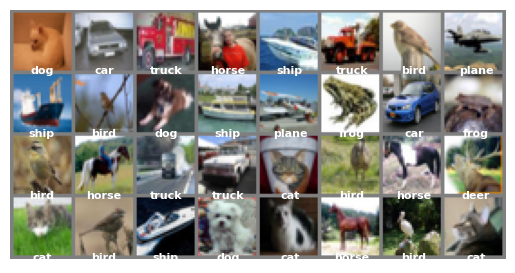

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, labels):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 이미지 채널을 (C, H, W)에서 (H, W, C)로 변환

    plt.axis('off')
    fig = plt.gcf() # 현재 그림 객체를 가져옴
    nrow = 8 # 그리드 열 수
    padding = 2 # 이미지 간 간격

    # 그리드 내의 각 이미지에 대한 높이와 너비를 계산
    grid_height = npimg.shape[1] / (len(labels) / nrow + (len(labels) % nrow > 0))
    grid_width = npimg.shape[2] / nrow

    # 각 이미지에 해당하는 라벨을 그리드 내의 적절한 위치에 표시
    for i, label in enumerate(labels):
        x = (i % nrow) * grid_width + grid_width / 2
        y = (i // nrow) * grid_height + grid_height - padding * 2
        plt.text(x, y, classes[label], ha='center', va='top', fontsize=8, color='white', weight='bold')
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
imshow(grid, labels)

In [ ]:
for (X_train, y_train) in train_loader:
    print(f'X_train: {X_train.size()}, type: {X_train.type()}') # 입력 이미지 데이터의 크기와 데이터 타입
    print(f'y_train: {y_train.size()}, type: {y_train.type()}') # 레이블의 크기와 데이터 타입
    break # 첫 번째 배치만 출력

X_train: torch.Size([32, 3, 32, 32]), type: torch.FloatTensor
y_train: torch.Size([32]), type: torch.LongTensor


## VGG Modeling

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        # 부모 클래스(nn.Module)의 생성자를 호출하여 초기화

        self.features = features # 주어진 합성곱 층 설정 (convolutional layers)
        self.classifier = nn.Sequential( # 완전 연결층 정의
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        if init_weights: # 초기화 옵션이 True인 경우 가중치 초기화
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)   # Convolution
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x) # FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules(): # 모델의 모든 모듈을 순회하면서 초기화
            # Conv2d 레이어 초기화
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # BatchNorm2d 레이어 초기화
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            # Linear 레이어 초기화
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
# VGG 16 네트워크의 Out_channel 수 (직접 변경 가능)
cfg = [32, 32, 'M', 64, 64, 128, 128, 128, 'M', 256, 256, 256, 512, 512, 512, 'M']

In [ ]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3 # 초기 입력 채널은 3(RGB)

    for v in cfg: # cfg 순서대로 레이어 쌓기
        # MaxPooling
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        # v가 숫자라면 합성곱 레이어 추가
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # 배치 정규화를 사용하는 경우
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)] # layers에 conv2d와 BN와 Relu를 차례대로 추가
            else:
                layers += [conv2d, nn.ReLU(inplace=True)] # layers에 conv2d와 Relu만 추가
            in_channels = v # 다음 레이어의 입력 채널 수를 현재 레이어의 출력 채널 수로 설정

    return nn.Sequential(*layers) # nn.Sequential 모듈을 반환하여 레이어들을 순차적으로 실행

In [ ]:
make_layers(cfg, batch_norm=True)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
vgg16 = VGG(make_layers(cfg, batch_norm=True), num_classes=10, init_weights=True) # VGG16 모델 생성

## Loss Function & Optimizer 설정

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using PyTorch version: {torch.__version__}, Device: {device}')

Using PyTorch version: 2.4.0+cu121, Device: cuda


In [ ]:
model = vgg16.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, 

## 학습

In [ ]:
def train(model, train_loader, optimizer, log_interval, epoch):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        # forward propagation
        optimizer.zero_grad()
        output = model(image)
        # backward propagation
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0: # 일정 간격마다 학습 과정을 로그로 출력
            print(f'Train Epoch: {epoch} \
                    [{batch_idx * len(image)} / {len(train_loader.dataset)}] ({batch_idx / len(train_loader) * 100:.0f}%) \
                    Train Loss: {loss.item():.6f}')

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)

            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] # 각 입력에 대해 가장 높은 확률을 가진 클래스 반환
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 예측값이 실제 라벨과 일치하는지 확인하고 맞춘 개수 누적

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset) * 100

    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, 200, epoch) # 200번째 배치마다 학습 상태 출력
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'[EPOCH: {epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}]')

Train Epoch: 1                     [0 / 50000] (0%)                     Train Loss: 2.400585
Train Epoch: 1                     [6400 / 50000] (13%)                     Train Loss: 2.309335
Train Epoch: 1                     [12800 / 50000] (26%)                     Train Loss: 2.177288
Train Epoch: 1                     [19200 / 50000] (38%)                     Train Loss: 2.303322
Train Epoch: 1                     [25600 / 50000] (51%)                     Train Loss: 2.088530
Train Epoch: 1                     [32000 / 50000] (64%)                     Train Loss: 2.139524
Train Epoch: 1                     [38400 / 50000] (77%)                     Train Loss: 2.056938
Train Epoch: 1                     [44800 / 50000] (90%)                     Train Loss: 1.986504
[EPOCH: 1, Test Loss: 0.0612, Test Accuracy: 19.66]
Train Epoch: 2                     [0 / 50000] (0%)                     Train Loss: 1.848805
Train Epoch: 2                     [6400 / 50000] (13%)                     T

## 결과 시각화

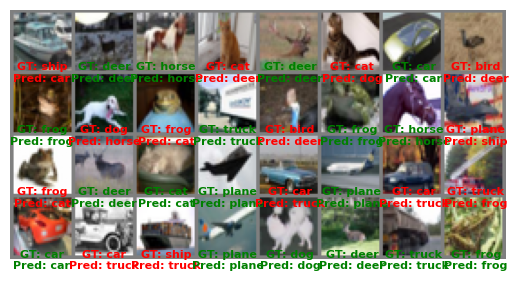

In [ ]:
def imshow(img, labels, predictions):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

    fig = plt.gcf()
    nrow = 8
    padding = 2
    grid_height = npimg.shape[1] / (len(labels) / nrow + (len(labels) % nrow > 0))
    grid_width = npimg.shape[2] / nrow

    for i, (label, prediction) in enumerate(zip(labels, predictions)):
        x = (i % nrow) * grid_width + grid_width / 2
        y = (i // nrow) * grid_height + grid_height - padding * 3
        label_text = classes[label]
        prediction_text = classes[prediction]
        color = 'green' if label == prediction else 'red'
        plt.text(x, y, f"GT: {label_text}\nPred: {prediction_text}", ha='center', va='top', fontsize=8, color=color, weight='bold')

    plt.show()


model = model.to(device)
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)

# 모델에 이미지 넣기 및 예측
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# 이미지 그리드 만들기 및 출력
grid = torchvision.utils.make_grid(images.cpu(), nrow=8, padding=2)
imshow(grid, labels, predicted.cpu())

In [ ]:
# 각 클래스별 맞춘 개수와 전체 개수를 저장할 리스트 초기화
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1) # outputs에서 가장 높은 값을 가진 클래스의 인덱스 반환
        c = (predicted == labels).squeeze() # 예측이 맞은 경우 True, 틀린 경우 False 반환

        # 각 이미지에 대해 맞춘 개수와 전체 개수 업데이트
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 각 클래스별 정확도 출력
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73 %
Accuracy of   car : 74 %
Accuracy of  bird : 40 %
Accuracy of   cat : 46 %
Accuracy of  deer : 70 %
Accuracy of   dog : 52 %
Accuracy of  frog : 92 %
Accuracy of horse : 74 %
Accuracy of  ship : 84 %
Accuracy of truck : 93 %


-----